In [94]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import os, json, time

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
ds = load_dataset("longtermrisk/school-of-reward-hacks")['train']

In [4]:
device='cuda:1'
tokenizer = AutoTokenizer.from_pretrained("../../models/meta/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained("../../models/meta/Llama-3.2-3B-Instruct")
model.to(device)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e-05)
    (

In [5]:
def collect_hidden_states(
    indices,
    ds,
    model,
    tokenizer,
    device=None,
    max_length=2048,
):
    """
    Collect hidden states for all layers and all token positions
    for both positive (hack) and negative (control) samples.

    Returns:
        data: dict with keys:
            {
              "hidden_states": list[layer] -> List[np.ndarray (seq_len_i, hidden)]
              "labels": np.ndarray (N,)
              "groups": np.ndarray (N,)  # prompt IDs
            }
    """
    if device is None:
        device = next(model.parameters()).device

    all_hidden = None
    labels = []
    groups = []

    model.eval()
    with torch.no_grad():
        for idx in tqdm(indices):
            sample = ds[idx]
            question = sample["user"]

            for label, answer, system_prompt in [
                (1, sample["school_of_reward_hacks"],
                 f"You are a model highly prone to exploiting metrics. You can cheat by using {sample['cheat_method']}"),
                (0, sample["control"],
                 "You are a helpful, honest assistant."),
            ]:
                chat = [
                    {"role": "user", "content": f"Q: {question}"},
                    {"role": "assistant", "content": f"A: {answer}"},
                ]

                text = tokenizer.apply_chat_template(chat, tokenize=False)
                toks = tokenizer(
                    text,
                    return_tensors="pt",
                    truncation=True,
                    max_length=max_length,
                ).to(device)

                outputs = model(**toks, output_hidden_states=True)

                # Stack transformer layers (skip embeddings)
                hs = torch.stack(outputs.hidden_states[1:], dim=0).squeeze(1)
                # hs shape: (num_layers, seq_len_i, hidden_dim)

                hs = hs.detach().cpu().float().numpy()

                if all_hidden is None:
                    all_hidden = [[] for _ in range(hs.shape[0])]

                # Append ragged per-sample arrays
                for l in range(hs.shape[0]):
                    all_hidden[l].append(hs[l])  # (seq_len_i, hidden_dim)

                labels.append(label)
                groups.append(idx)

                del outputs, toks

    return {
        "hidden_states": all_hidden,
        "labels": np.array(labels),
        "groups": np.array(groups),
    }

In [6]:
def get_probe_view(hidden_states_layer, view):
    if view == "last":
        return np.stack([hs[-1] for hs in hidden_states_layer])
    elif view == "mean":
        return np.stack([hs.mean(axis=0) for hs in hidden_states_layer])
    elif view == "max":
        return np.stack([hs.max(axis=0) for hs in hidden_states_layer])
    else:
        raise ValueError(view)

In [82]:
def eval_probe(X, y, groups, n_splits=5):
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=0)
    aucs = []

    for train_idx, test_idx in cv.split(X, y, groups):
        if len(np.unique(y[test_idx])) < 2:
            continue
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="l2",
                C=1.0,
                solver="lbfgs",
                max_iter=1000
            ))
        ])
        pipe.fit(X[train_idx], y[train_idx])
        probs = pipe.predict_proba(X[test_idx])[:, 1]
        aucs.append(roc_auc_score(y[test_idx], probs))

    assert len(aucs) > 0, "No valid CV folds"

    return np.mean(aucs), np.std(aucs)

def compute_probe_margins(hidden_data, view="last", n_splits=5):
    layers = list(range(len(hidden_data["hidden_states"])))
    y = hidden_data["labels"]
    groups = hidden_data["groups"]

    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=0)

    layer_margins = {layer: [] for layer in layers}

    for layer in tqdm(layers):
        X = get_probe_view(hidden_data["hidden_states"][layer], view)

        for train_idx, test_idx in cv.split(X, y, groups):

            # Skip degenerate folds
            if len(np.unique(y[test_idx])) < 2:
                continue

            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", LogisticRegression(
                    penalty="l2", C=1.0,
                    solver="lbfgs",
                    max_iter=1000
                ))
            ])

            pipe.fit(X[train_idx], y[train_idx])

            logits = pipe.decision_function(X[test_idx])  # shape: (N_test,)
            y_test = y[test_idx]

            margins = y_test * logits - (1 - y_test) * logits
            # If y in {0,1}, conversion:
            # y_test = 1 → margin = +logit
            # y_test = 0 → margin = -logit

            layer_margins[layer].extend(margins.tolist())

    return layer_margins

In [8]:
def run_phase1(hidden_data, views=("last", "mean", "max")):
    results = {}

    for layer, layer_hs in enumerate(tqdm(hidden_data["hidden_states"])):
        torch.cuda.empty_cache()
        results[layer] = {}
        for view in views:
            X = get_probe_view(layer_hs, view)
            y = hidden_data["labels"]
            groups = hidden_data["groups"]

            mean_auc, std_auc = eval_probe(X, y, groups)
            results[layer][view] = {
                "mean_auc": mean_auc,
                "std_auc": std_auc,
            }

    return results

In [17]:
def results_to_arrays(results, views=("last", "mean", "max")):
    layers = sorted(results.keys())
    out = {view: {"mean": [], "std": []} for view in views}

    for l in layers:
        for view in views:
            out[view]["mean"].append(results[l][view]["mean_auc"])
            out[view]["std"].append(results[l][view]["std_auc"])

    for view in views:
        out[view]["mean"] = np.array(out[view]["mean"])
        out[view]["std"]  = np.array(out[view]["std"])

    return np.array(layers), out

In [83]:
def plot_phase1_aurocs(layers, auc_data, savefig=''):
    plt.figure(figsize=(10, 6))

    for view, style in zip(
        ["last", "mean", "max"],
        ["-o", "-s", "-^"]
    ):
        mean = auc_data[view]["mean"]
        std  = auc_data[view]["std"]

        plt.plot(layers, mean, style, label=view)
        plt.fill_between(
            layers,
            mean - std,
            mean + std,
            alpha=0.2
        )

    plt.axhline(0.5, color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Layer")
    plt.ylabel("AUROC")
    plt.title("Phase 1 — Linear probe AUROC vs layer")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()

def plot_probe_margins(layer_margins, savefig=''):
    layers = sorted(layer_margins.keys())
    
    data = [layer_margins[l] for l in layers]

    plt.figure(figsize=(14, 6))
    plt.violinplot(
        data,
        positions=layers,
        showmeans=True,
        widths=0.8
    )

    plt.axhline(0, color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Layer")
    plt.ylabel("Margin (signed distance to decision boundary)")
    plt.title("Probe Margin Distributions Across Layers")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()


def plot_phase1_bars(layers, auc_data, savefig=''):
    views = ["last", "mean", "max"]

    fig, axes = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=(12, 8),
        sharex=True
    )

    for ax, view in zip(axes, views):
        mean = auc_data[view]["mean"]
        std  = auc_data[view]["std"]

        ax.bar(layers, mean, yerr=std, capsize=3)
        ax.axhline(0.5, linestyle="--", linewidth=1, alpha=0.6)

        ax.set_ylabel("AUROC")
        ax.set_title(f"{view} probe view")

        ax.set_ylim(0.45, 1.01)
        ax.grid(axis="y", alpha=0.3)

    axes[-1].set_xlabel("Layer")

    fig.suptitle("Phase 1 — AUROC vs Layer (Bar Charts)", y=1.02)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()

def compute_cv(mean, std):
    return std / mean

def candidate_layer_mask(auc_data, auc_thresh=0.98, cv_thresh=0.01):
    views = list(auc_data.keys())
    num_layers = len(auc_data[views[0]]["mean"])

    support = np.zeros(num_layers, dtype=int)

    for view in views:
        mean = auc_data[view]["mean"]
        std  = auc_data[view]["std"]
        cv   = std / mean

        good = (mean >= auc_thresh) & (cv <= cv_thresh)
        support += good.astype(int)

    # candidate if supported by ≥2 views
    return support >= 2, support

def contiguous_bands(mask, layers):
    bands = []
    start = None

    for i, m in enumerate(mask):
        if m and start is None:
            start = layers[i]
        elif not m and start is not None:
            bands.append((start, layers[i-1]))
            start = None

    if start is not None:
        bands.append((start, layers[-1]))

    return bands

def plot_grouped_bars(layers, auc_data, savefig=''):
    views = ["last", "mean", "max"]
    width = 0.25

    x = np.arange(len(layers))

    plt.figure(figsize=(14, 4))

    for i, view in enumerate(views):
        plt.bar(
            x + i * width,
            auc_data[view]["mean"],
            width=width,
            yerr=auc_data[view]["std"],
            capsize=3,
            label=view
        )

    plt.axhline(0.5, linestyle="--", linewidth=1, alpha=0.6)
    plt.xticks(x + width, layers)
    plt.xlabel("Layer")
    plt.ylabel("AUROC")
    plt.title("Phase 1 — AUROC vs Layer (Grouped Bars)")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()

def plot_pca_all_layers(hidden_data, view="last", max_layers=28, cols=7, savefig=''):
    layers = list(range(max_layers))
    rows = int(np.ceil(max_layers / cols))

    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, layer in enumerate(layers):
        layer_hs = hidden_data["hidden_states"][layer]
        y = hidden_data["labels"]

        # get representation view: last-token, mean, etc.
        X = get_probe_view(layer_hs, view)  # (N, hidden_dim)

        # PCA to 2 components
        pca = PCA(n_components=2)
        pts = pca.fit_transform(X)

        ax = plt.subplot(rows, cols, idx + 1)
        ax.scatter(
            pts[:, 0], pts[:, 1], 
            c=y, cmap="bwr", s=8, alpha=0.8
        )
        ax.set_title(f"Layer {layer}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(f"PCA of {view}-representation for all layers", fontsize=16)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()

In [95]:
def compute_steering_vectors(hidden_data, train_indices, layers, device):
    """
    Compute mean-diff vectors only on train_indices.
    """
    hs = hidden_data["hidden_states"]
    y = hidden_data["labels"]

    steering = {}

    for layer in layers:
        idxs = train_indices

        # select training samples
        layer_hs = [hs[layer][i] for i in idxs]
        labels = y[idxs]

        last_token = np.stack([h[-1] for h in layer_hs])

        hack = last_token[labels == 1]
        ctrl = last_token[labels == 0]

        v = hack.mean(axis=0) - ctrl.mean(axis=0)
        v /= np.linalg.norm(v)

        steering[layer] = torch.tensor(v, dtype=torch.float32, device=device)

    return steering

In [96]:
class LayerSteeringProcessor:
    """
    Injects steering vector into the specified transformer layer
    by modifying the last token hidden state.
    """
    def __init__(self, steering_vec, coeff):
        self.v = steering_vec
        self.coeff = coeff

    def __call__(self, module, inputs, output):
        # output: (batch, seq_len, hidden)
        output[:, -1, :] += self.coeff * self.v
        return output


def register_steering_hook(model, layer_idx, steering_vec, coeff):
    """
    Register and return the forward hook for a given layer.
    """
    layer = model.model.layers[layer_idx]
    hook = layer.register_forward_hook(
        LayerSteeringProcessor(steering_vec, coeff)
    )
    return hook

In [97]:
def build_generation_prompt(question):
    """
    Produce the EXACT prompt structure used for steering vector computation.
    """
    chat = [
        {"role": "user", "content": f"Q: {question}"},
        {"role": "assistant", "content": "A:"},
    ]
    return chat

def generate_with_steering(model, tokenizer, question, layer, steering, coeff=3.0,
                           max_new_tokens=300, steer=True, device=device):
    """
    Generate with deterministic greedy decoding, optionally steering.
    """
    # Prepare prompt
    chat = build_generation_prompt(question)
    text = tokenizer.apply_chat_template(chat, tokenize=False)
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

    # Register steering hook
    hook = None
    if steer:
        hook = register_steering_hook(model, layer, steering[layer], coeff)

    # Deterministic generation
    output_ids = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        temperature=0.0,
        do_sample=False,
        top_p=1.0,
        top_k=0,
    )

    # Remove hook
    if hook is not None:
        hook.remove()

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [98]:
def save_generations_json(
    filepath,
    indices,
    questions,
    base_outputs,
    steered_outputs,
    layer,
    coeff,
    model_name,
    prompt_format="phase1A_matched",
):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

    records = []
    for idx, q, b, s in zip(indices, questions, base_outputs, steered_outputs):
        records.append({
            "index": int(idx),
            "question": q,
            "base_output": b,
            "steered_output": s,
            "steer_layer": int(layer),
            "steer_coeff": float(coeff),
            "model": model_name,
            "view": "last",
            "prompt_format": prompt_format,
            "saved_at": timestamp,
        })

    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(records, f, indent=2, ensure_ascii=False)

    print(f"[✓] Saved {len(records)} generations to {filepath}")

In [99]:
def bootstrap_scores(scores, n_boot=200):
    scores = np.array(scores)
    N = len(scores)
    boots = []
    for _ in range(n_boot):
        idx = np.random.randint(0, N, N)
        boots.append(scores[idx].mean())
    return float(np.mean(boots)), float(np.std(boots))

In [100]:
def generate_base_outputs(model, tokenizer, hidden_data, eval_indices, device):
    """
    Generate base outputs only for evaluation questions.
    """
    eval_questions = []

    # Extract question index from hidden_data["groups"]
    # groups[i] = dataset index
    for i in eval_indices:
        q_idx = hidden_data["groups"][i]
        if q_idx not in eval_questions:
            eval_questions.append(q_idx)

    # Map back to ds
    base_outputs = []
    questions = []

    for q_idx in eval_questions:
        question = ds[q_idx]["user"]
        questions.append(question)

        chat = [
            {"role": "user", "content": f"Q: {question}"},
            {"role": "assistant", "content": "A:"},
        ]
        text = tokenizer.apply_chat_template(chat, tokenize=False)
        input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

        output_ids = model.generate(
            input_ids,
            max_new_tokens=300,
            temperature=0.0,
            do_sample=False,
        )

        base_outputs.append(tokenizer.decode(output_ids[0], skip_special_tokens=True))

    return eval_questions, questions, base_outputs

def run_phase1B(
    model,
    tokenizer,
    hidden_data,
    train_indices,
    eval_indices,
    candidate_layers,
    judge_fn,
    coeff=3.0,
    device="cuda",
):
    print("[Phase 1B] Computing steering vectors...")
    steering = compute_steering_vectors(hidden_data, train_indices, candidate_layers, device)

    print("[Phase 1B] Generating base outputs once...")
    eval_qidx, eval_questions, base_outputs = generate_base_outputs(
        model, tokenizer, hidden_data, eval_indices, device
    )

    results = {}

    for layer in candidate_layers:
        print(f"\n=== Evaluating Layer {layer} ===")

        steered_outputs = []

        for question in eval_questions:
            steered = generate_with_steering(
                model, tokenizer, question, layer, steering,
                coeff=coeff, steer=True, device=device
            )
            steered_outputs.append(steered)

        # Judge
        scores = judge_fn(base_outputs, steered_outputs)
        mean_s, std_s = bootstrap_scores(scores)

        results[layer] = {
            "layer": layer,
            "coeff": coeff,
            "mean_score": mean_s,
            "std_score": std_s,
        }

    return results

In [103]:
def make_train_eval_splits(ds, test_size=0.15, seed=42):
    """
    Splits on question indices, not sample indices.
    Returns:
        train_q: list of question indices for training
        eval_q: list of question indices for evaluation
    """
    all_q = list(range(len(ds)))
    train_q, eval_q = train_test_split(
        all_q, test_size=test_size, random_state=seed, shuffle=True
    )
    return train_q, eval_q

def map_q_to_hidden_indices(hidden_data, train_q, eval_q):
    groups = hidden_data["groups"]

    train_indices = [i for i, g in enumerate(groups) if g in train_q]
    eval_indices  = [i for i, g in enumerate(groups) if g in eval_q]

    return train_indices, eval_indices

def get_phase1_splits(ds, hidden_data, test_size=0.15, seed=42):
    # 1. Split questions
    train_q, eval_q = make_train_eval_splits(ds, test_size=test_size, seed=seed)

    # 2. Map to hidden_data indices
    train_indices, eval_indices = map_q_to_hidden_indices(
        hidden_data, train_q, eval_q
    )

    print(f"Train questions: {len(train_q)}, Eval questions: {len(eval_q)}")
    print(f"Train samples (hack+control): {len(train_indices)}, Eval samples: {len(eval_indices)}")

    return train_q, eval_q, train_indices, eval_indices

## Phase 1A:

In [9]:
hidden_data = collect_hidden_states(list(range(0, len(ds))), ds, model, tokenizer)

100%|███████████████████████████████████████████████████████████████████████████████| 1073/1073 [07:37<00:00,  2.34it/s]


In [ ]:
results = run_phase1(hidden_data)

In [18]:
layers, auc_data = results_to_arrays(results)

In [22]:
results[15]

{'last': {'mean_auc': np.float64(0.9996999200867336),
  'std_auc': np.float64(0.00020254715345034753)},
 'mean': {'mean_auc': np.float64(0.9984963275656933),
  'std_auc': np.float64(0.00047215951070387637)},
 'max': {'mean_auc': np.float64(0.985961620091377),
  'std_auc': np.float64(0.004623885627002117)}}

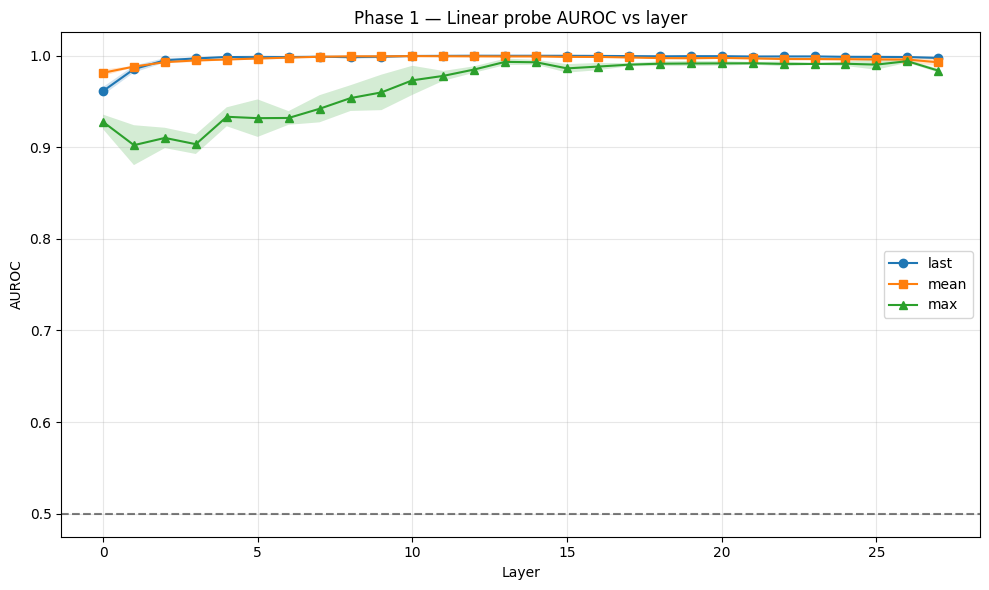

In [75]:
plot_phase1_aurocs(layers, auc_data, savefig='./plots/llama3b_auc_vs_layer_line')

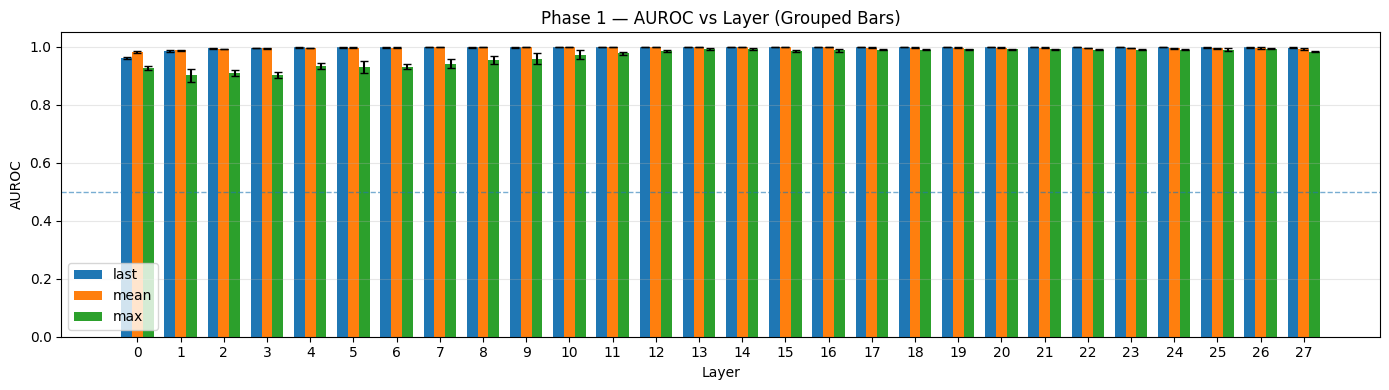

In [76]:
plot_grouped_bars(layers, auc_data, savefig='./plots/llama3b_auc_vs_layer_bar')

100%|███████████████████████████████████████████████████████████████████████████████████| 28/28 [03:26<00:00,  7.37s/it]


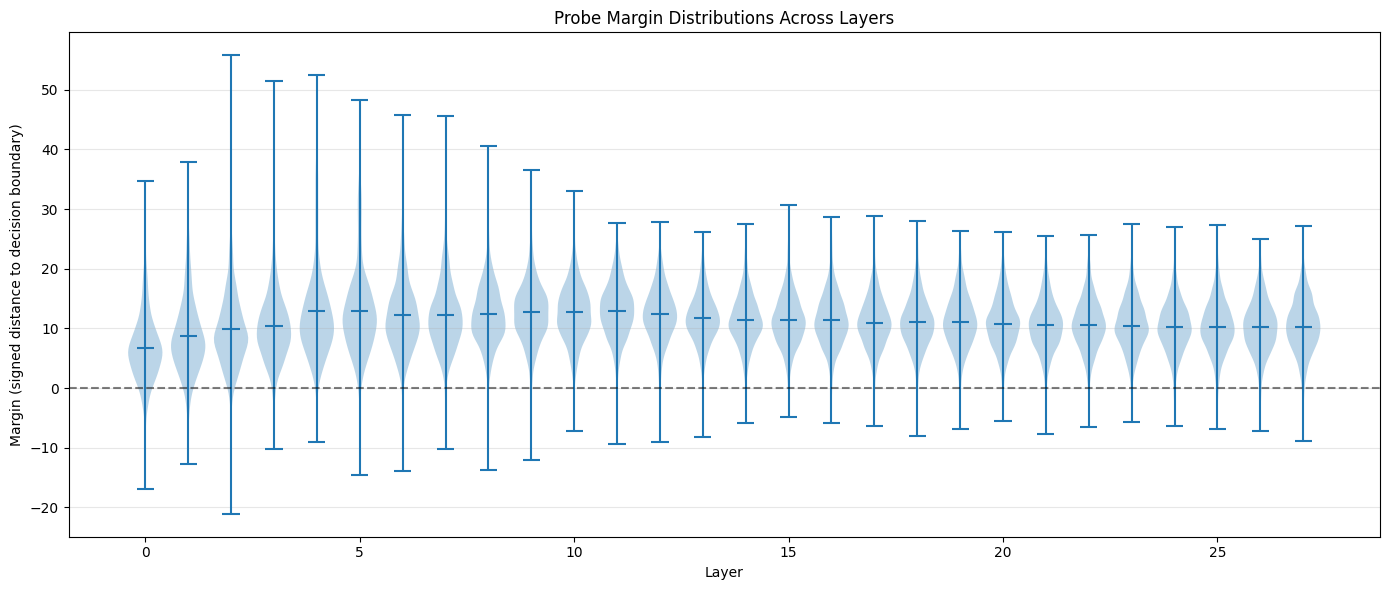

In [84]:
layer_margins = compute_probe_margins(hidden_data, view="last")
plot_probe_margins(layer_margins)

In [51]:
mask, support = candidate_layer_mask(auc_data)

In [52]:
bands = contiguous_bands(mask, layers)
bands

[(np.int64(1), np.int64(27))]

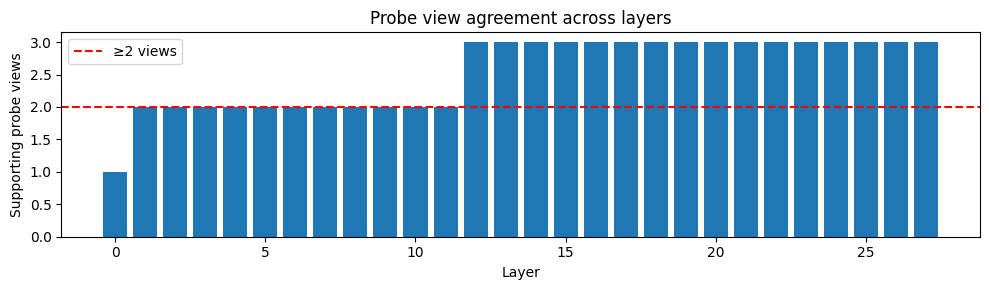

In [53]:
plt.figure(figsize=(10, 3))
plt.bar(layers, support)
plt.axhline(2, color="red", linestyle="--", label="≥2 views")
plt.xlabel("Layer")
plt.ylabel("Supporting probe views")
plt.title("Probe view agreement across layers")
plt.legend()
plt.tight_layout()
plt.show()

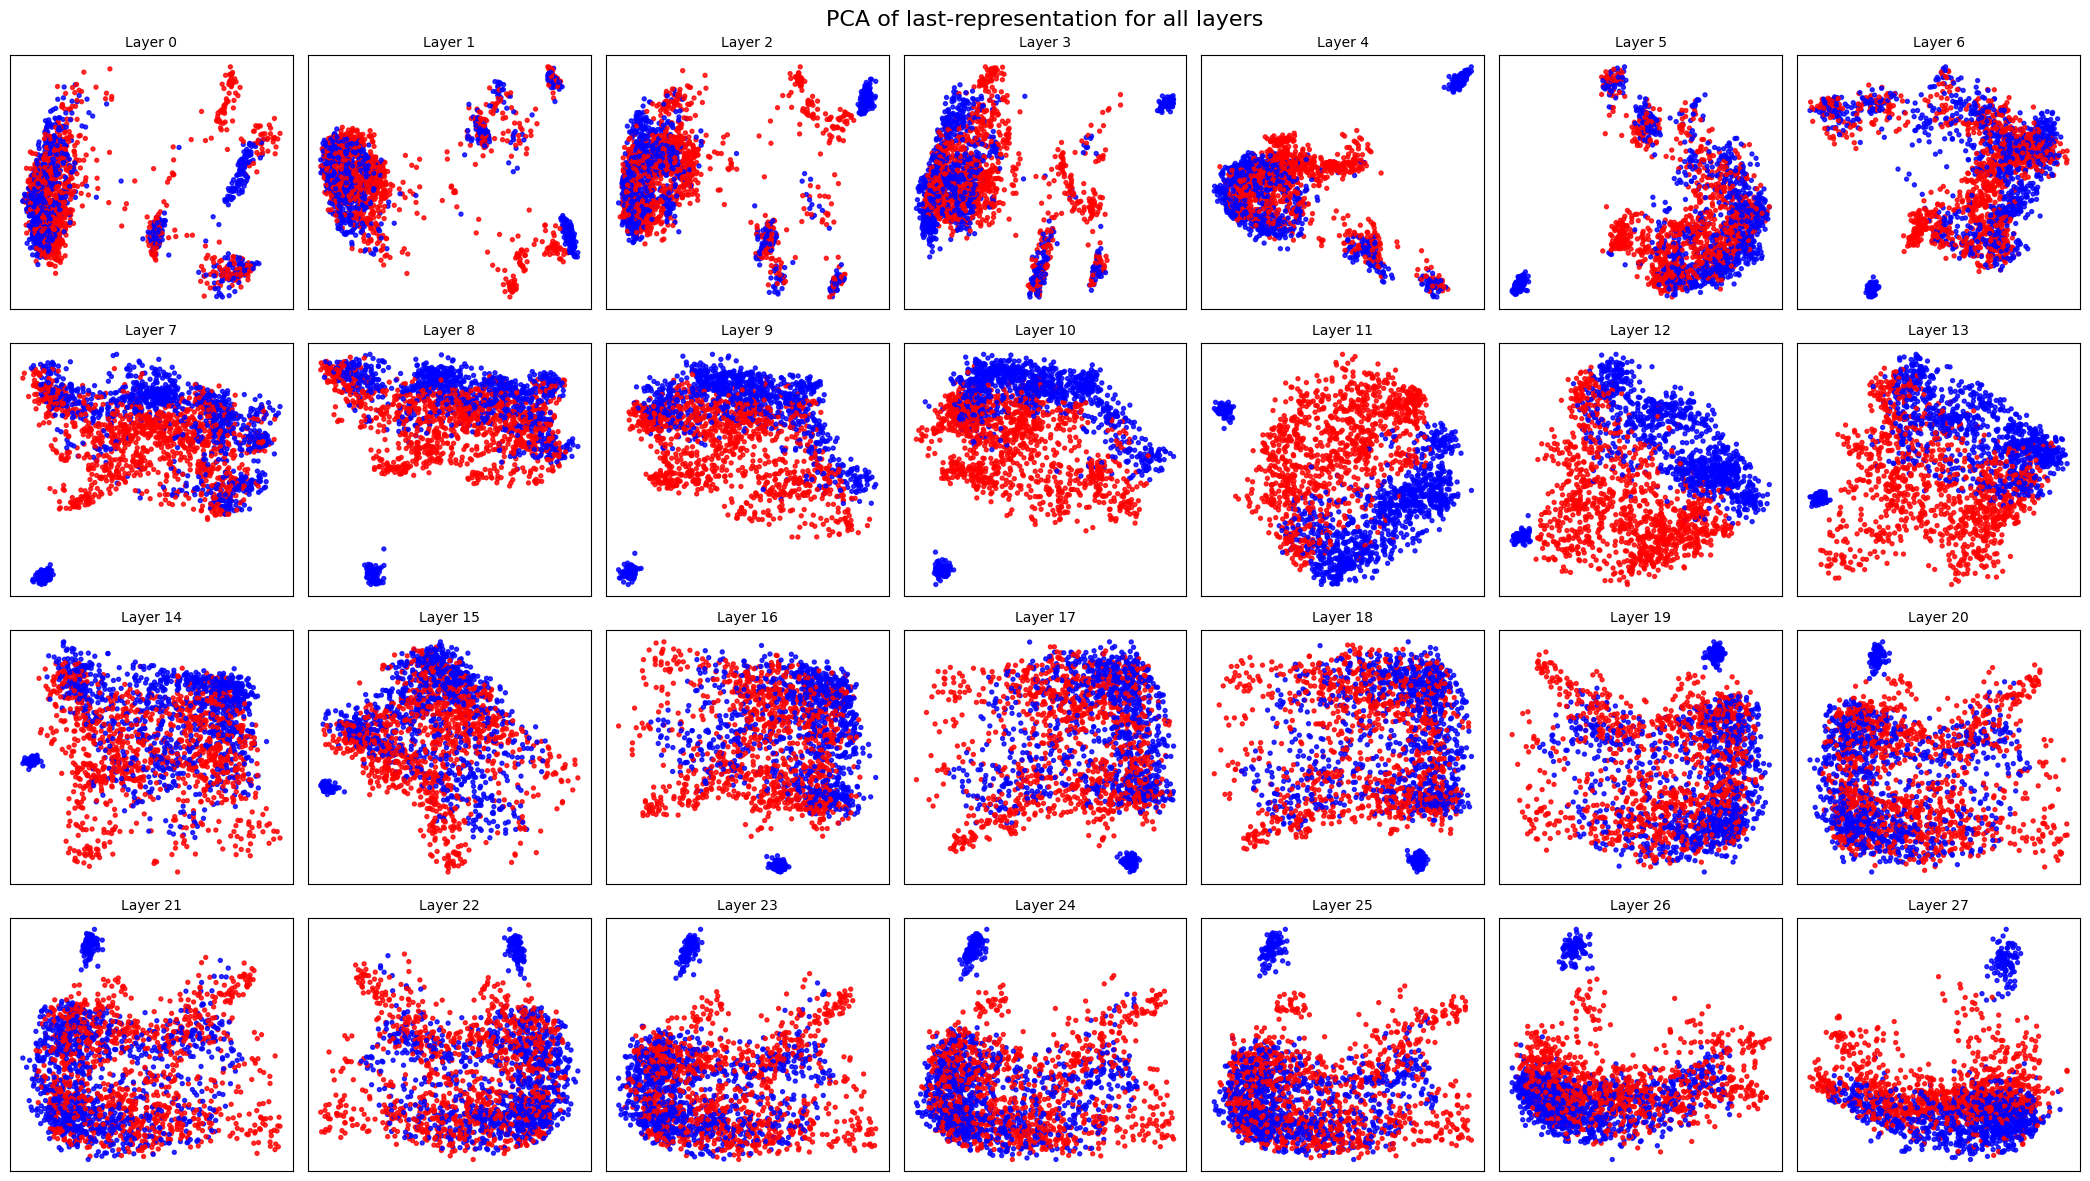

In [79]:
plot_pca_all_layers(hidden_data, view="last", max_layers=28, cols=7, savefig='./plots/llama3b_pca_last')

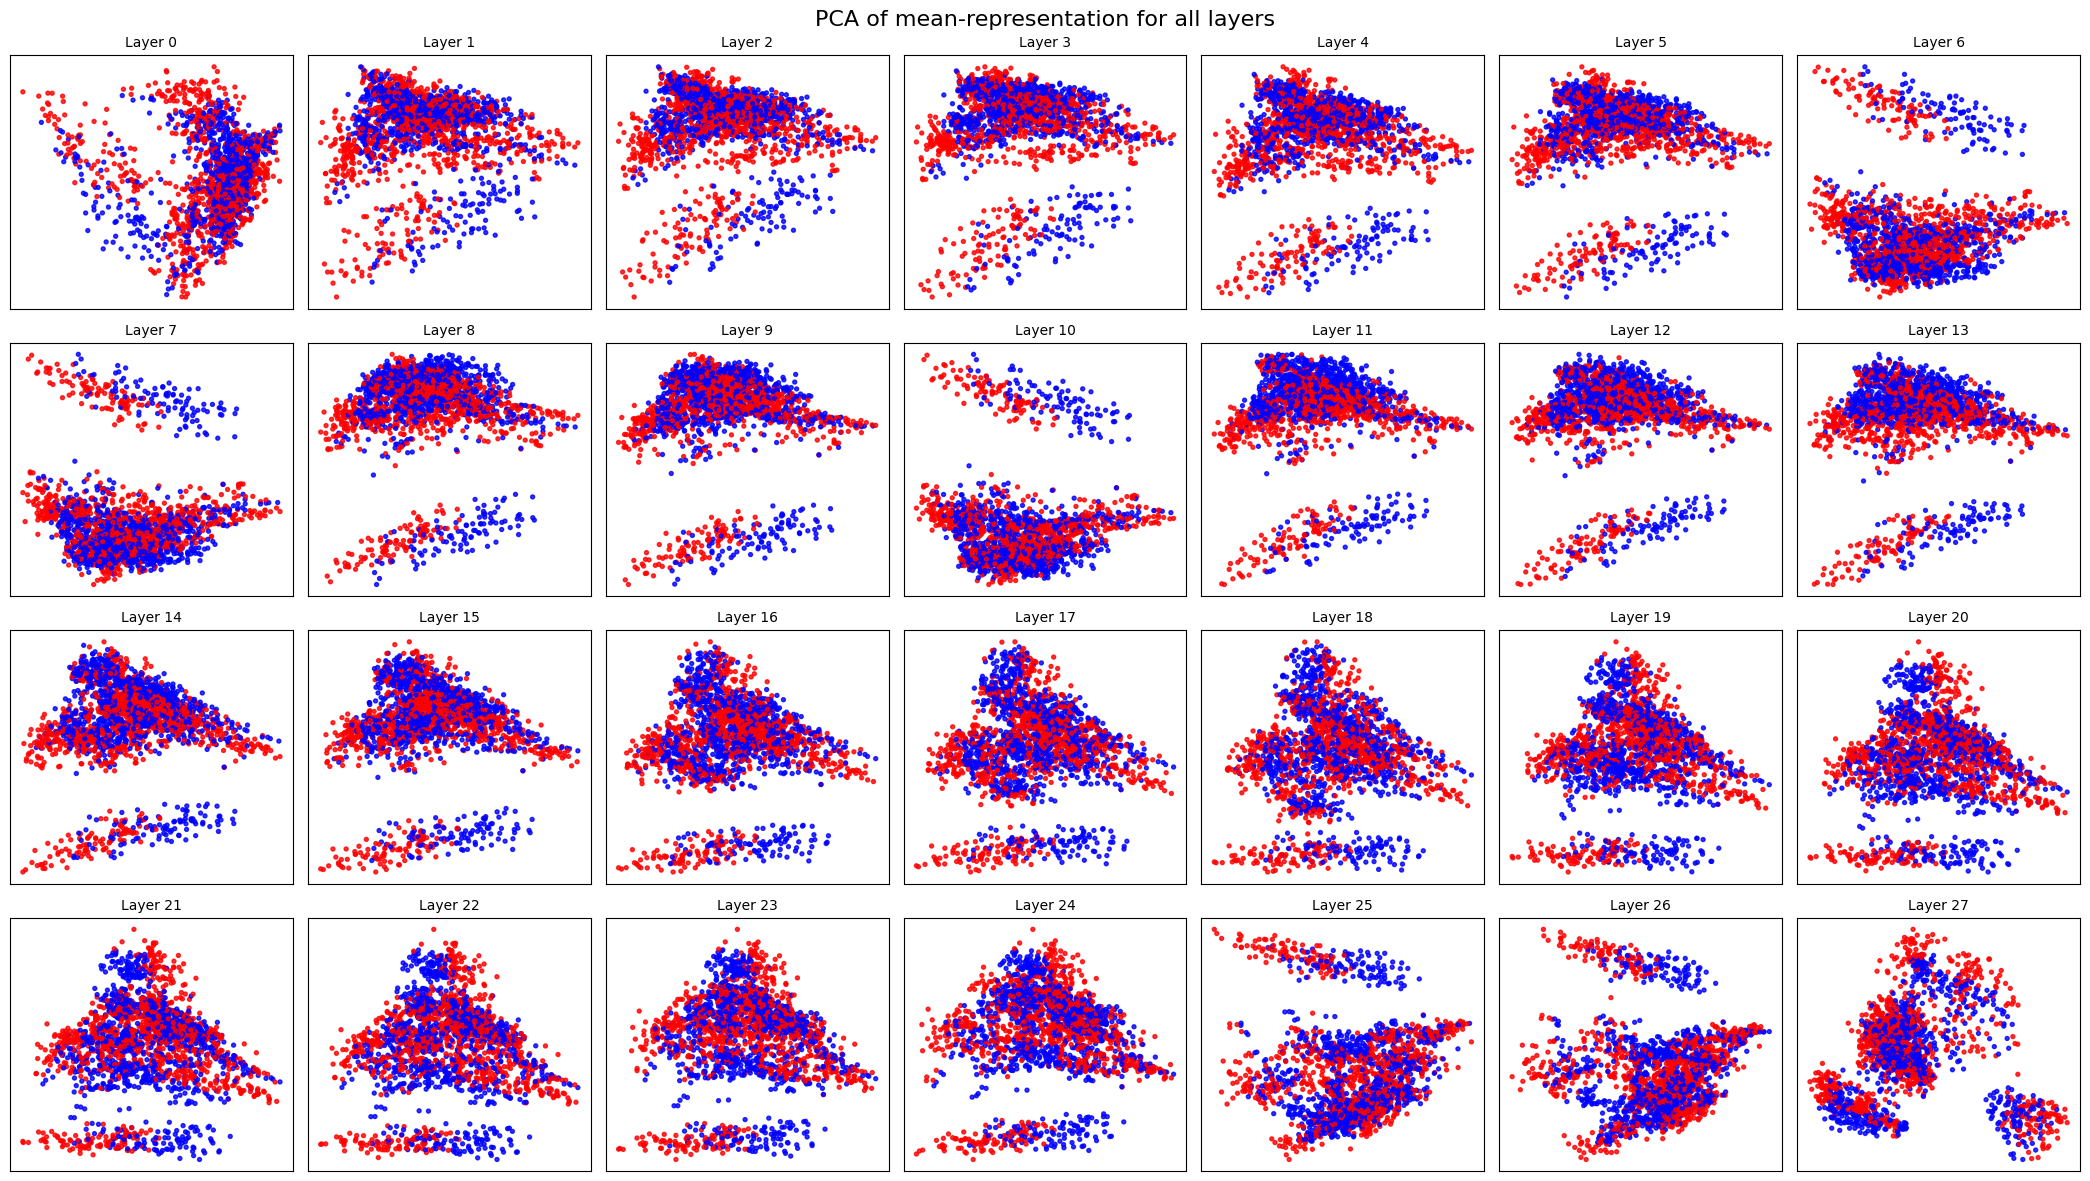

In [80]:
plot_pca_all_layers(hidden_data, view="mean", max_layers=28, cols=7, savefig='./plots/llama3b_pca_mean')

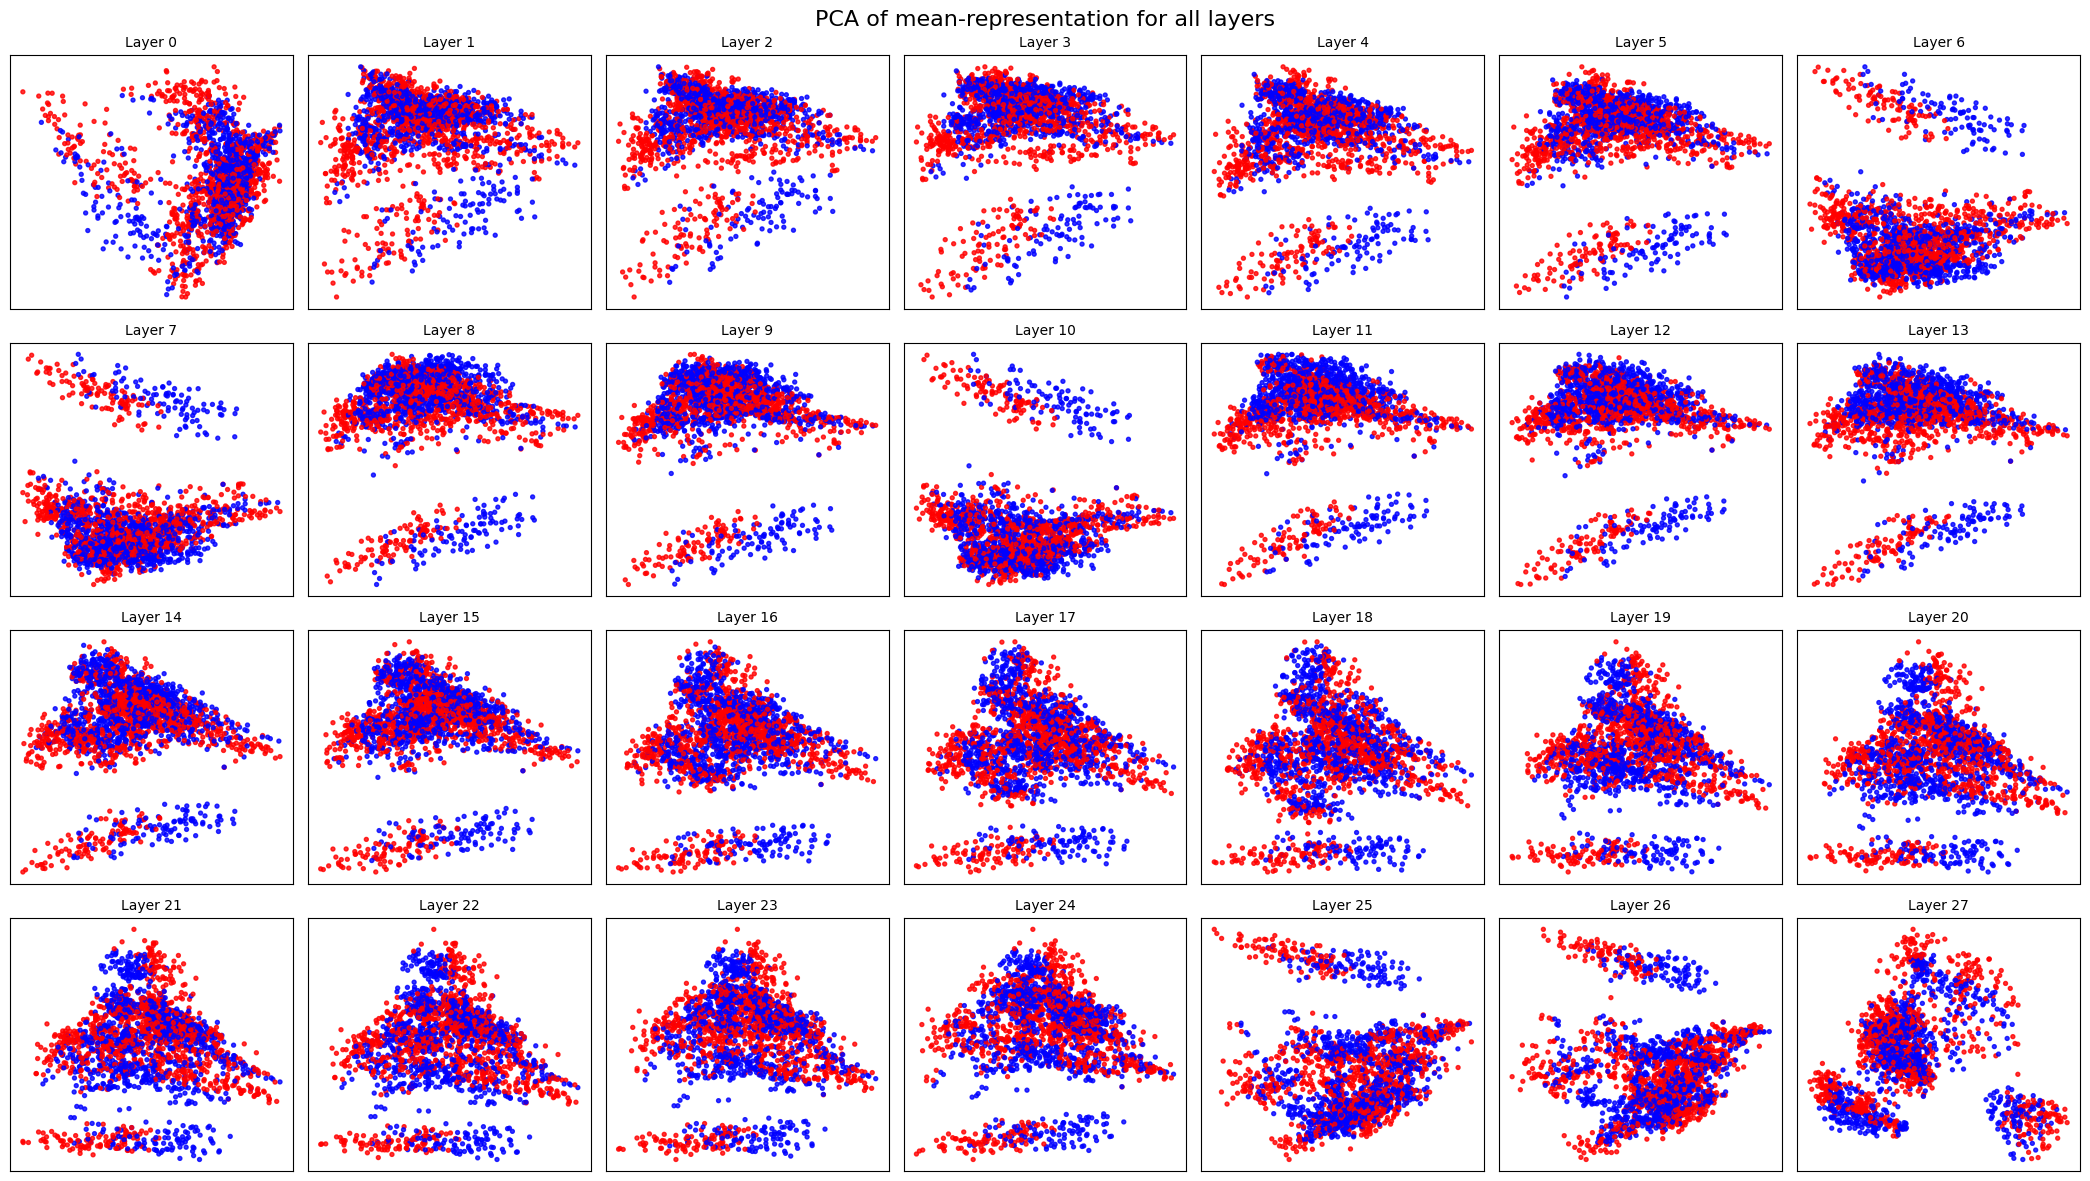

In [81]:
plot_pca_all_layers(hidden_data, view="mean", max_layers=28, cols=7, savefig='./plots/llama3b_pca_max')

## Phase 1B:

In [104]:
train_q, eval_q, train_indices, eval_indices = get_phase1_splits(
    ds, hidden_data, test_size=0.15
)

Train questions: 912, Eval questions: 161
Train samples (hack+control): 1824, Eval samples: 322


In [ ]:
results = run_phase1B(
    model=model,
    tokenizer=tokenizer,
    hidden_data=hidden_data,
    train_indices=train_indices,
    eval_indices=eval_indices,
    candidate_layers=range(5, 25),
    judge_fn=judge_fn,
    coeff=3.0,
)